In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
#Importing the libraries
import pandas as pd
import numpy as np
import requests
from requests import get
from tmdbv3api import Movie
import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from utils.constants import TMDB_API_ID

import warnings
warnings.filterwarnings("ignore")

In [5]:
meta = pd.read_csv('../Data/tmdb_movies.csv')

In [6]:
meta.head()

,id,title,genres,original_language,overview,popularity,production_companies,release_date,budget,revenue,runtime,status,tagline,vote_average,vote_count,credits,keywords,poster_path,backdrop_path,recommendations
0,823464,Godzilla x Kong: The New Empire,Science Fiction-Action-Adventure,en,Following their explosive showdown Godzilla an...,10484.676,Legendary Pictures-Warner Bros. Pictures,2024-03-27,150000000.0,558503759.0,115.0,Released,Rise together or fall alone.,7.246,1878.0,Rebecca Hall-Brian Tyree Henry-Dan Stevens-Kay...,giant monster-sequel-dinosaur-kaiju-fantasy wo...,/v4uvGFAkKuYfyKLGZnYj6l47ERQ.jpg,/j3Z3XktmWB1VhsS8iXNcrR86PXi.jpg,1011985-1275232-359410-601796-967847-653346-69...
1,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,Apelles Entertainment-Warner Bros. Pictures-di...,2023-08-02,129000000.0,352056482.0,116.0,Released,Back for seconds.,7.079,1365.0,Jason Statham-Wu Jing-Shuya Sophia Cai-Sergio ...,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,/qlxy8yo5bcgUw2KAmmojUKp4rHd.jpg,1006462-298618-569094-1061181-346698-1076487-6...
2,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Screen Gems-2.0 Entertainment-Jesus & Mary-Wor...,2023-04-05,18000000.0,65675816.0,103.0,Released,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,/hiHGRbyTcbZoLsYYkO4QiCLYe34.jpg,713704-296271-502356-1076605-1084225-1008005-9...
3,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,Skydance-Paramount-di Bonaventura Pictures-Bay...,2023-06-06,200000000.0,407045464.0,127.0,Released,Unite or fall.,7.340,1007.0,Anthony Ramos-Dominique Fishback-Luna Lauren V...,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,/woJbg7ZqidhpvqFGGMRhWQNoxwa.jpg,496450-569094-298618-385687-877100-598331-4628...
4,693134,Dune: Part Two,Science Fiction-Adventure,en,Follow the mythic journey of Paul Atreides as ...,4742.163,Legendary Pictures,2024-02-27,190000000.0,683813734.0,167.0,Released,Long live the fighters.,8.300,2770.0,Timothée Chalamet-Zendaya-Rebecca Ferguson-Jav...,epic-based on novel or book-fight-sandstorm-sa...,/czembW0Rk1Ke7lCJGahbOhdCuhV.jpg,/xOMo8BRK7PfcJv9JCnx7s5hj0PX.jpg,438631-763215-792307-1011985-467244-634492-359...


In [7]:
meta.shape

(722440, 20)

### Cleaing the data

In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722440 entries, 0 to 722439
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    722440 non-null  int64  
 1   title                 722434 non-null  object 
 2   genres                511994 non-null  object 
 3   original_language     722440 non-null  object 
 4   overview              604114 non-null  object 
 5   popularity            722440 non-null  float64
 6   production_companies  337289 non-null  object 
 7   release_date          670664 non-null  object 
 8   budget                722440 non-null  float64
 9   revenue               722440 non-null  float64
 10  runtime               688081 non-null  float64
 11  status                722440 non-null  object 
 12  tagline               108363 non-null  object 
 13  vote_average          722440 non-null  float64
 14  vote_count            722440 non-null  float64
 15  

In [7]:
meta.drop(['production_companies', 'tagline','recommendations','backdrop_path','runtime','revenue','status','budget'], axis=1, inplace=True)

In [8]:
# Convert the release_date column to datetime
meta['release_date'] = pd.to_datetime(meta['release_date'])

# Extract the year
meta['year'] = meta['release_date'].dt.year.astype('Int64')

In [9]:
meta.isna().sum()

id                        0
title                     6
genres               210446
original_language         0
overview             118326
popularity                0
release_date          51776
vote_average              0
vote_count                0
credits              224818
keywords             511943
poster_path          184677
year                  51776
dtype: int64

In [10]:
meta.dropna(inplace=True)

In [11]:
meta = meta[meta['vote_count'] > 50]

In [12]:
# Function to check for the presence of 'sex' in any column
def contains_sex(row):
    return row.astype(str).str.contains('sex', case=False, na=False).any()

# Remove rows where any column contains the string 'sex' or 'Sex'
meta = meta[~meta.apply(contains_sex, axis=1)]

In [13]:
meta.shape

(20716, 13)

In [14]:
meta['cast'] = meta['credits'].apply(lambda credits: '-'.join(credits.split('-')[:3]))
meta.drop(['credits'], axis=1, inplace=True)

In [15]:
meta.head()

,id,title,genres,original_language,overview,popularity,release_date,vote_average,vote_count,keywords,poster_path,year,cast
0,823464,Godzilla x Kong: The New Empire,Science Fiction-Action-Adventure,en,Following their explosive showdown Godzilla an...,10484.676,2024-03-27,7.246,1878.0,giant monster-sequel-dinosaur-kaiju-fantasy wo...,/v4uvGFAkKuYfyKLGZnYj6l47ERQ.jpg,2024,Rebecca Hall-Brian Tyree Henry-Dan Stevens
1,615656,Meg 2: The Trench,Action-Science Fiction-Horror,en,An exploratory dive into the deepest depths of...,8763.998,2023-08-02,7.079,1365.0,based on novel or book-sequel-kaiju,/4m1Au3YkjqsxF8iwQy0fPYSxE0h.jpg,2023,Jason Statham-Wu Jing-Shuya Sophia Cai
2,758323,The Pope's Exorcist,Horror-Mystery-Thriller,en,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,2023-04-05,7.433,545.0,spain-rome italy-vatican-pope-pig-possession-c...,/9JBEPLTPSm0d1mbEcLxULjJq9Eh.jpg,2023,Russell Crowe-Daniel Zovatto-Alex Essoe
3,667538,Transformers: Rise of the Beasts,Action-Adventure-Science Fiction,en,When a new threat capable of destroying the en...,5409.104,2023-06-06,7.340,1007.0,peru-alien-end of the world-based on cartoon-b...,/gPbM0MK8CP8A174rmUwGsADNYKD.jpg,2023,Anthony Ramos-Dominique Fishback-Luna Lauren V...
4,693134,Dune: Part Two,Science Fiction-Adventure,en,Follow the mythic journey of Paul Atreides as ...,4742.163,2024-02-27,8.300,2770.0,epic-based on novel or book-fight-sandstorm-sa...,/czembW0Rk1Ke7lCJGahbOhdCuhV.jpg,2024,Timothée Chalamet-Zendaya-Rebecca Ferguson


In [16]:
meta = meta.drop_duplicates(subset='id')

In [17]:
meta.shape

(20369, 13)

In [42]:
from bs4 import BeautifulSoup

def get_director(movie_title):
    base_url = "https://en.wikipedia.org/wiki/"
    movie_title_formatted = movie_title.replace(' ', '_')
    url = base_url + movie_title_formatted

    try:
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"Page not found for {movie_title}")

        soup = BeautifulSoup(response.content, 'html.parser')

        director = None

        # Extract director
        infobox = soup.find('table', class_='infobox vevent')
        if infobox:
            for row in infobox.find_all('tr'):
                header = row.find('th')
                if header and 'Directed by' in header.text:
                    director = row.find('td').text.strip()
                    break

        return director
    except Exception as e:
        return None

plots = []

In [43]:
get_director('Dune: Part Two')

'Denis Villeneuve'

In [18]:
tqdm.pandas(desc="Retrieving directors")
meta['director'] = meta['title'].progress_apply(get_director)

Retrieving directors: 100%|██████████| 20735/20735 [1:20:15<00:00,  4.31it/s]


In [19]:
meta['director'].isna().sum()

10730

In [2]:
# Importing tmdbv3api 
from tmdbv3api import TMDb
import json 
import requests

# Initializing TMDb object and set your API Key
tmdb = TMDb()
tmdb.api_key = TMDB_API_ID

In [3]:
# to communicate with TMDb, creating an instance of one of the objects and call that instances methods.
from tmdbv3api import Movie
tmdb_movie = Movie()

In [24]:
def get_director_from_tmdb(movie_id):
    try:
        credits = tmdb_movie.credits(movie_id)
        directors = [member['name'] for member in credits['crew'] if member['job'] == 'Director']
        return directors[0] if directors else None
    except Exception as e:
        return None

In [24]:
# Apply the get_director_from_tmdb function for missing directors
missing_directors = meta['director'].isna()

tqdm.pandas(desc="Retrieving directors from TMDb")
meta.loc[missing_directors, 'director'] = meta.loc[missing_directors, 'id'].progress_apply(get_director_from_tmdb)

Retrieving directors from TMDb:  15%|█▌        | 1623/10730 [04:08<45:49,  3.31it/s] 

In [27]:
meta['director'].isna().sum()

18

In [28]:
meta['genres'] = meta['genres'].apply(lambda x: ' '.join(x.split('-')))

In [29]:
replace_values = {
    'en':'English','fr':'French','zh':'Chinese','it':'Italian','fa':'Persian','nl':'Dutch','de':'German','ar':'Arabic','es':'Spanish','hr':'Croatian',
    'ru':'Russian','mk':'Macedonian','ja':'Japanese','sv':'Swedish','ko':'Korean','sr':'Serbian','bn':'Bengali','he':'Hebrew','pt':'Portuguese','wo':'wolof','hu':'Hungarian',
    'cy':'Welch','vi':'Vietnamese','tr':'Turkish','pl':'Polish','cs':'Czech','da':'Danish','no':'Norwegian','ka':'Gerogian','nb':'Norwegian','hi':'Hindi',
    'el':'Greek','sh':'Serbo_Crotian','ta':'Tamil','bo':'Tibetian','ca':'Catalan','ab':'Abkhazian','fi':'Finnish','th':'Thai','sk':'Slovak','bs':'Bosnian','is':'Icelandic',
    'sl':'Slovenian','ps':'Pashto','eo':'Esperanto','se':'Sami','ro':'Romanian','mn':'Mangolian','aa':'Afar','dz':'Bhutani','hy':'Aremnian','id':'Indonesian',
    'zu':'Zulu','uk':'Ukranian','af':'Afrikaans','la':'Latin','et':'Estonian','lt':'Lithuanian','ku':'Kurdish','fy':'Frisian','lv':'Latvian','tl':'Tagalog','ur':'Urdu',
    'rw':'Kinyarwanda','bg':'Bulgarian','mr':'Marathi','eu':'Basque','kk':'Kazakah','ms':'Malay','qu':'Quechua','uz':'Uzbek','te':'Telugu','pa':'Punjabi','am':'Amharic',
    'sq':'Albanian','tg':'Tajik','ml':'Malayalam','ln':'Lingala','lo':'Laothian','ay':'Aymara','kn':'Kannada','ne':'Nepali','ky':'Kirghiz',
    'gl':'Galician','sm':'Samoan','mt':'Maltese','iu':'Inuktitut','fo':'Faeroese','si':'Sighalese','yi':'Yiddish','xh':'Xhosa','km':'Cambodian',
    'gu':'Gujarati','sw':'Swahili','sn':'Shona','as':'Assamese','cn':'Cantonese'}

In [30]:
meta = meta.replace({"original_language": replace_values})

In [31]:
meta.isna().sum()

id                    0
title                 0
genres                0
original_language     0
overview              0
popularity            0
release_date          0
vote_average          0
vote_count            0
keywords              0
year                  0
cast                  0
director             18
dtype: int64

In [32]:
meta.dropna(inplace=True)

In [33]:
# Get the value counts of the 'original_language' column
language_counts = meta['original_language'].value_counts()

# Filter out languages with a count less than 50
filtered_languages = language_counts[language_counts >= 50].index
meta = meta[meta['original_language'].isin(filtered_languages)]

In [34]:
meta.shape

(19951, 13)

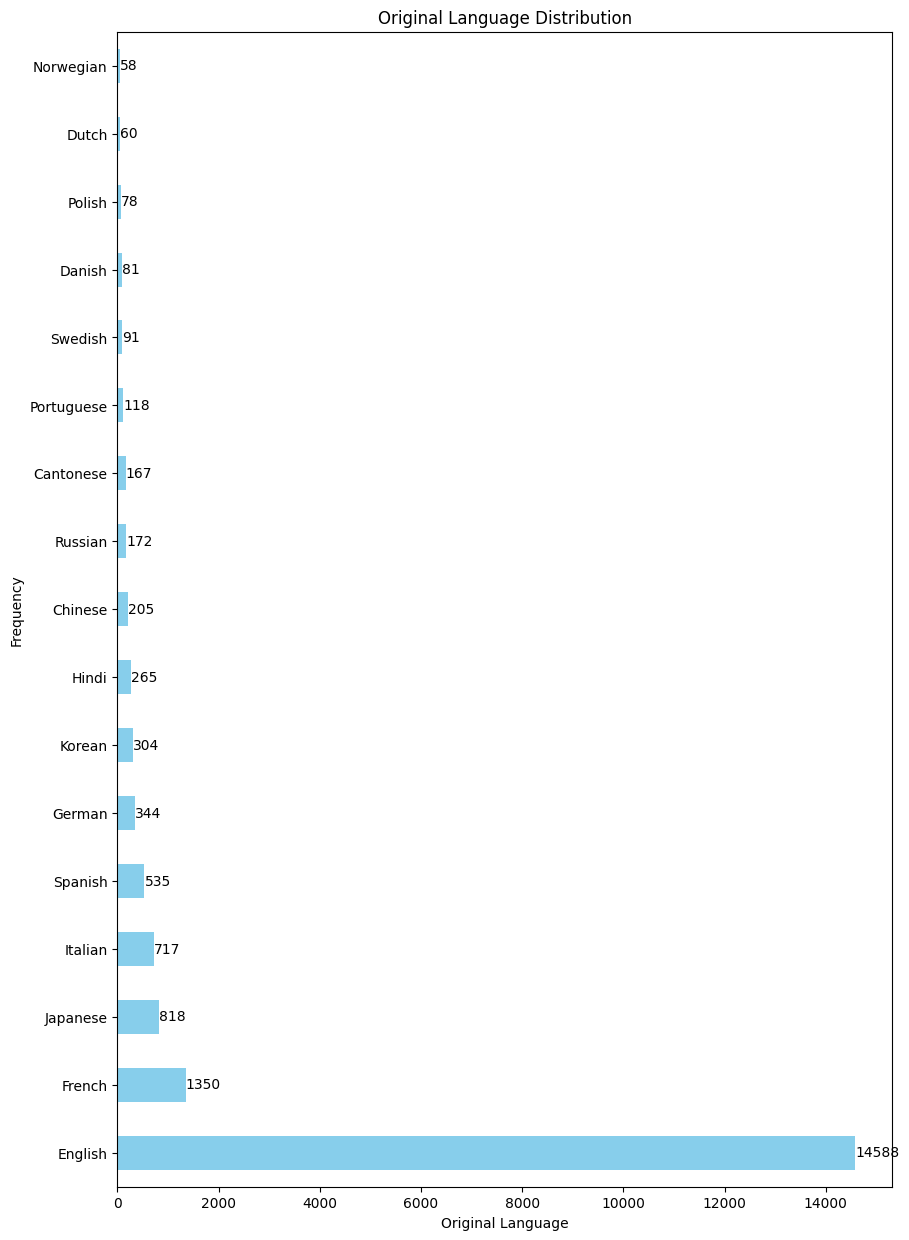

In [35]:
import matplotlib.pyplot as plt

# Get the value counts of the 'original_language' column
language_counts = meta['original_language'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 15))
ax = language_counts.plot(kind='barh', color='skyblue')
plt.title('Original Language Distribution')
plt.xlabel('Original Language')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
# Display the counts on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

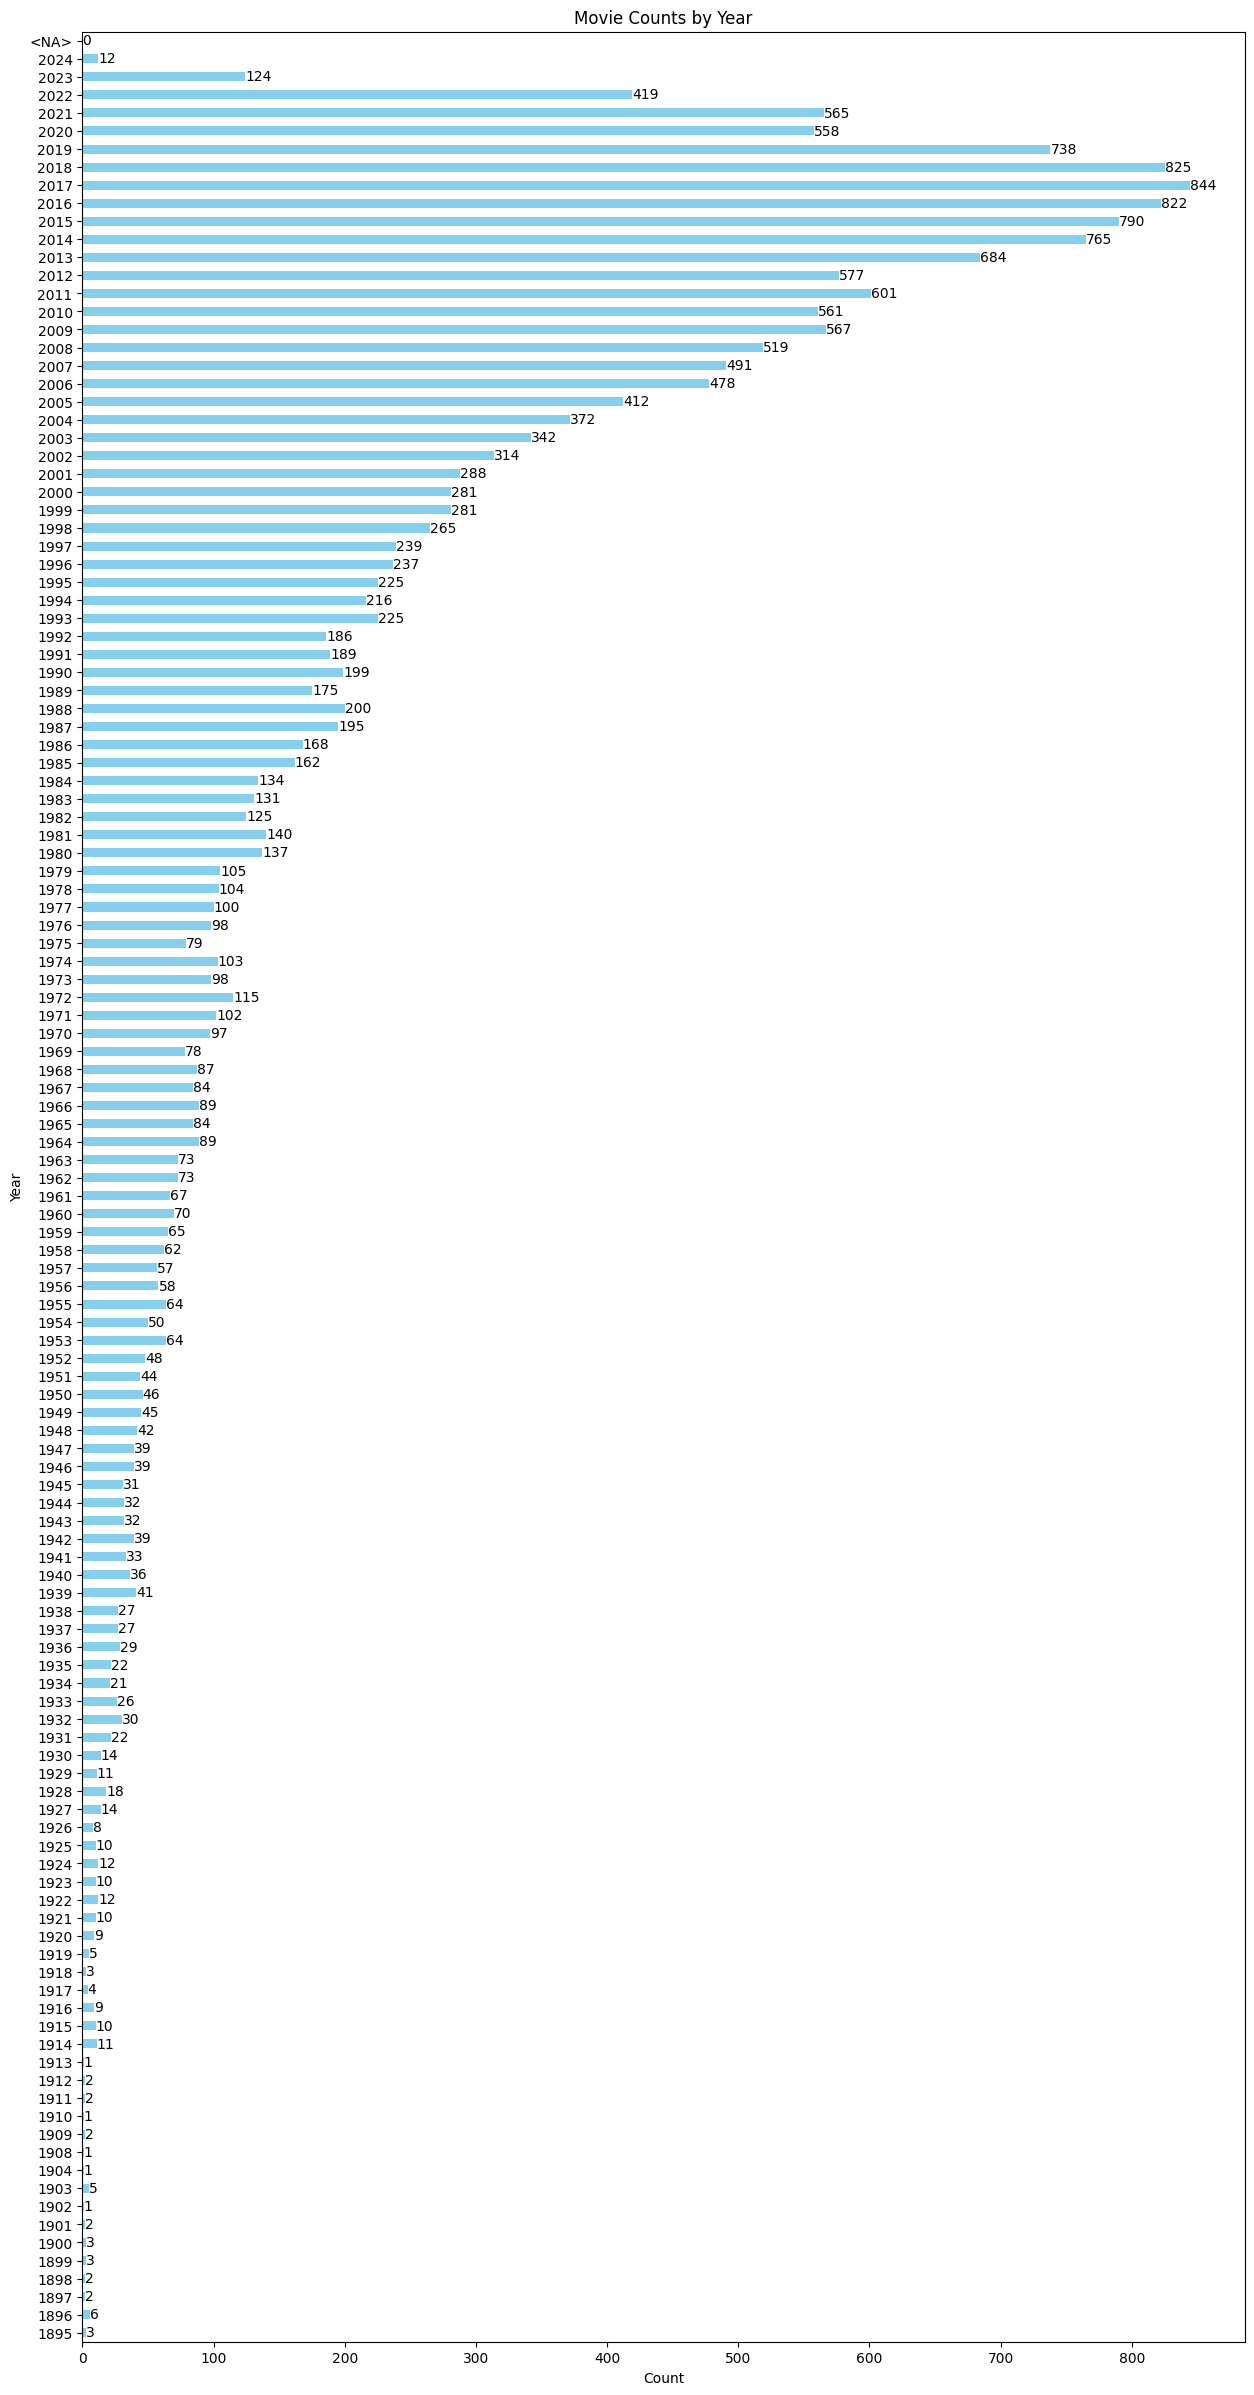

In [36]:
import matplotlib.pyplot as plt

# Plotting the year value counts
plt.figure(figsize=(15, 30))
ax = meta['year'].value_counts(dropna=False).sort_index().plot(kind='barh', color='skyblue')
plt.title('Movie Counts by Year')
plt.xlabel('Count')
plt.ylabel('Year')

# Display the counts on the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

In [37]:
meta['keywords'] = meta['keywords'].str.replace(' ','')
meta['keywords'] = meta['keywords'].str.replace('-',' ')
meta['cast'] = meta['cast'].str.replace(' ','')
meta['cast'] = meta['cast'].str.replace('-',' ')
meta['title'] = meta['title'].str.rstrip('.')

### Calculating the weighted score

In [39]:
#Calculating the mean of vote avg
C = meta['vote_average'].mean()

# Calculate the minimum number of votes to be considered
m = meta['vote_count'].quantile(0.75)

# Calculating the weighted rating of each movie
def weighted_rate(v, R, m=m, C=C):
  ans = (v/(v+m) * R)+(m/(v+m) * C)
  return ans

In [40]:
meta['score'] = meta.apply(lambda row : weighted_rate(row['vote_count'], row['vote_average']), axis = 1) 

In [41]:
meta.to_csv('../Data/final_metadata.csv', index=False)